In [1]:
import os
os.chdir('../')

In [2]:
import psycopg2
import pandas as pd
import numpy as np
import re
from datetime import datetime
from lib.pre_processing import money_toFloat, format_text, clean_county, top_features, score_me
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates
import matplotlib

matplotlib.style.use('ggplot')
%matplotlib inline

# Objective

Develope a analytics report for the Iowa State legislature regarding liquor sales who are considering changes to sales tax rates. Provide current liquor sales by county and projections for the rest of the year.

In [3]:
conn = psycopg2.connect(database='postgres', user='postgres', password='dsi_student', host='54.245.184.50', port='5432')
cur = conn.cursor()

In [4]:
cur.execute("""SELECT DATE_TRUNC('year', date) AS year, SUM(sale_dollars) 
               FROM iowa_sales
               GROUP BY year
               ORDER BY year ASC""")
rows = cur.fetchall()

# Explore the data

In [5]:
by_year = pd.read_pickle('data/sales_by_year.pkl')
by_year

,date,total_sales
0,2012-01-01,"$255,203,313.57"
1,2013-01-01,"$258,103,792.82"
2,2014-01-01,"$270,587,738.09"
3,2015-01-01,"$284,328,572.11"
4,2016-01-01,"$251,531,858.15"
5,2017-01-01,"$25,848,191.55"


In [6]:
#Set date to index to plot
by_year.set_index(['date'], inplace=True)

#Clean total_sales column
by_year['total_sales'] = money_toFloat(by_year['total_sales'])

###### Sales by Year

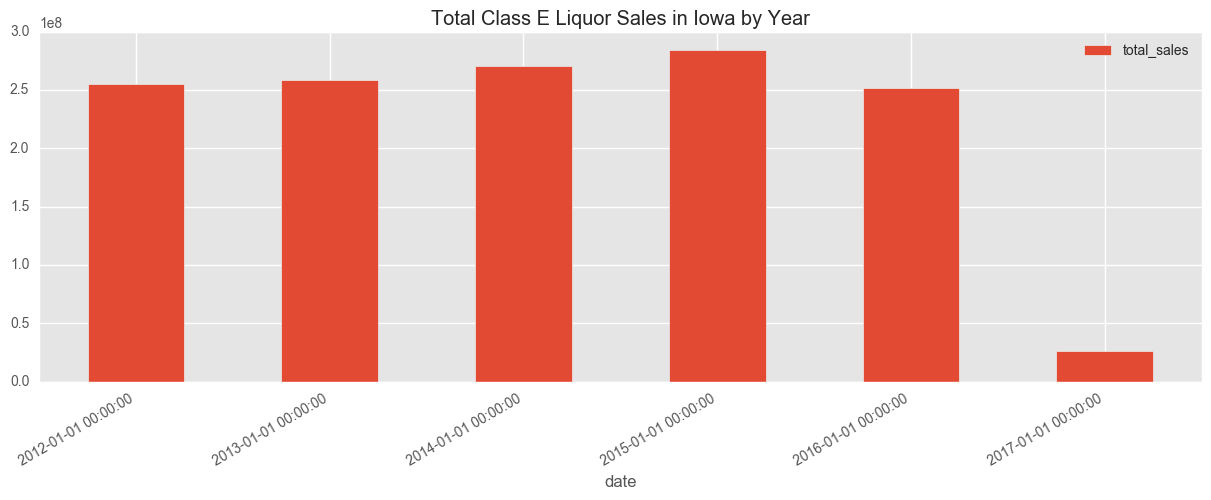

In [7]:
ax = by_year.plot.bar(figsize=(15,5), title="Total Class E Liquor Sales in Iowa by Year")
plt.gcf().autofmt_xdate()

In [8]:
cur.execute("""SELECT DATE_TRUNC('month', date) AS month, SUM(sale_dollars), county 
               FROM iowa_sales
               GROUP BY month, county
               ORDER BY month ASC""")
rows = cur.fetchall()

In [9]:
by_county = pd.read_pickle('data/sales_by_county.pkl')
by_county.dropna(inplace=True)

In [10]:
by_county['county'] = by_county['county'].apply(clean_county)
by_county['total_sales'] = money_toFloat(by_county['total_sales'])

In [11]:
by_county.to_csv('data/sales_by_county.csv')

In [12]:
county_pivot = pd.pivot_table(by_county, index='date', columns='county', values='total_sales')

###### Sales by County by Year

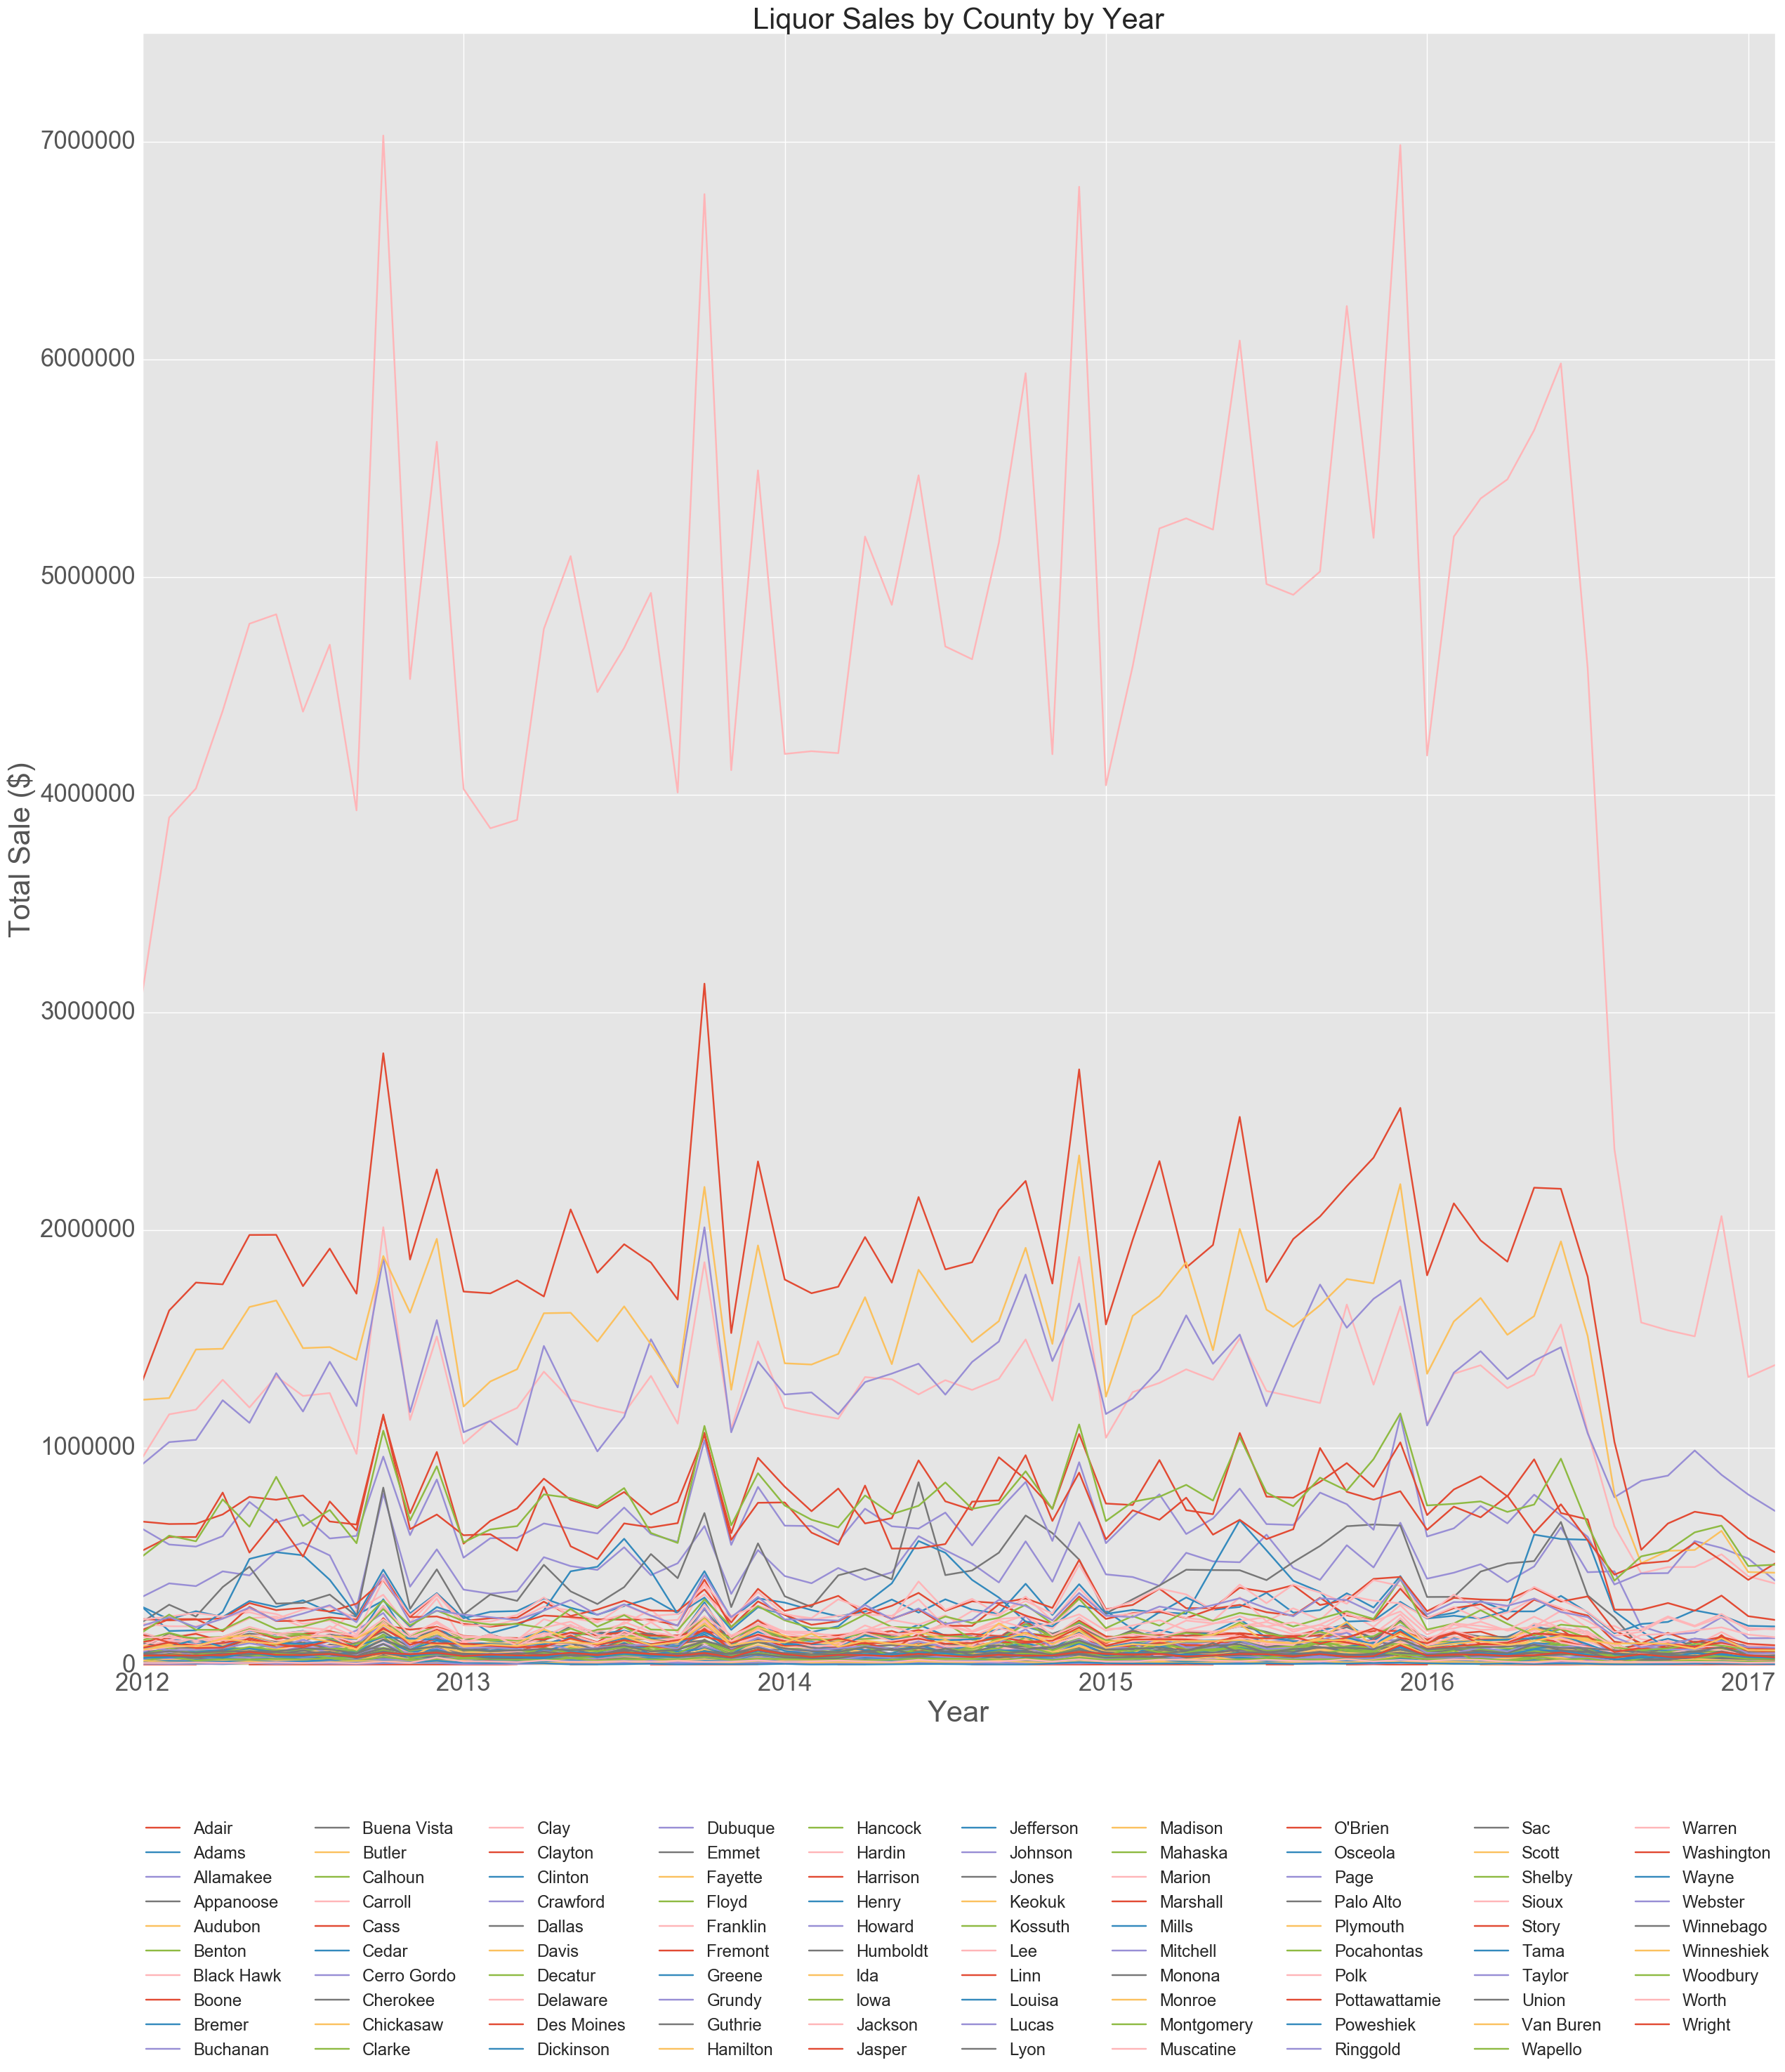

In [13]:
ax = county_pivot.plot(legend=False, figsize=(30,30), fontsize=25, ylim=(0,7500000))
ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Total Sale ($)', fontsize=30)
ax.set_title('Liquor Sales by County by Year', fontsize=30)
plt.legend(bbox_to_anchor=(0.5, -0.25), loc=8, ncol=10, fontsize='xx-large')
plt.show()

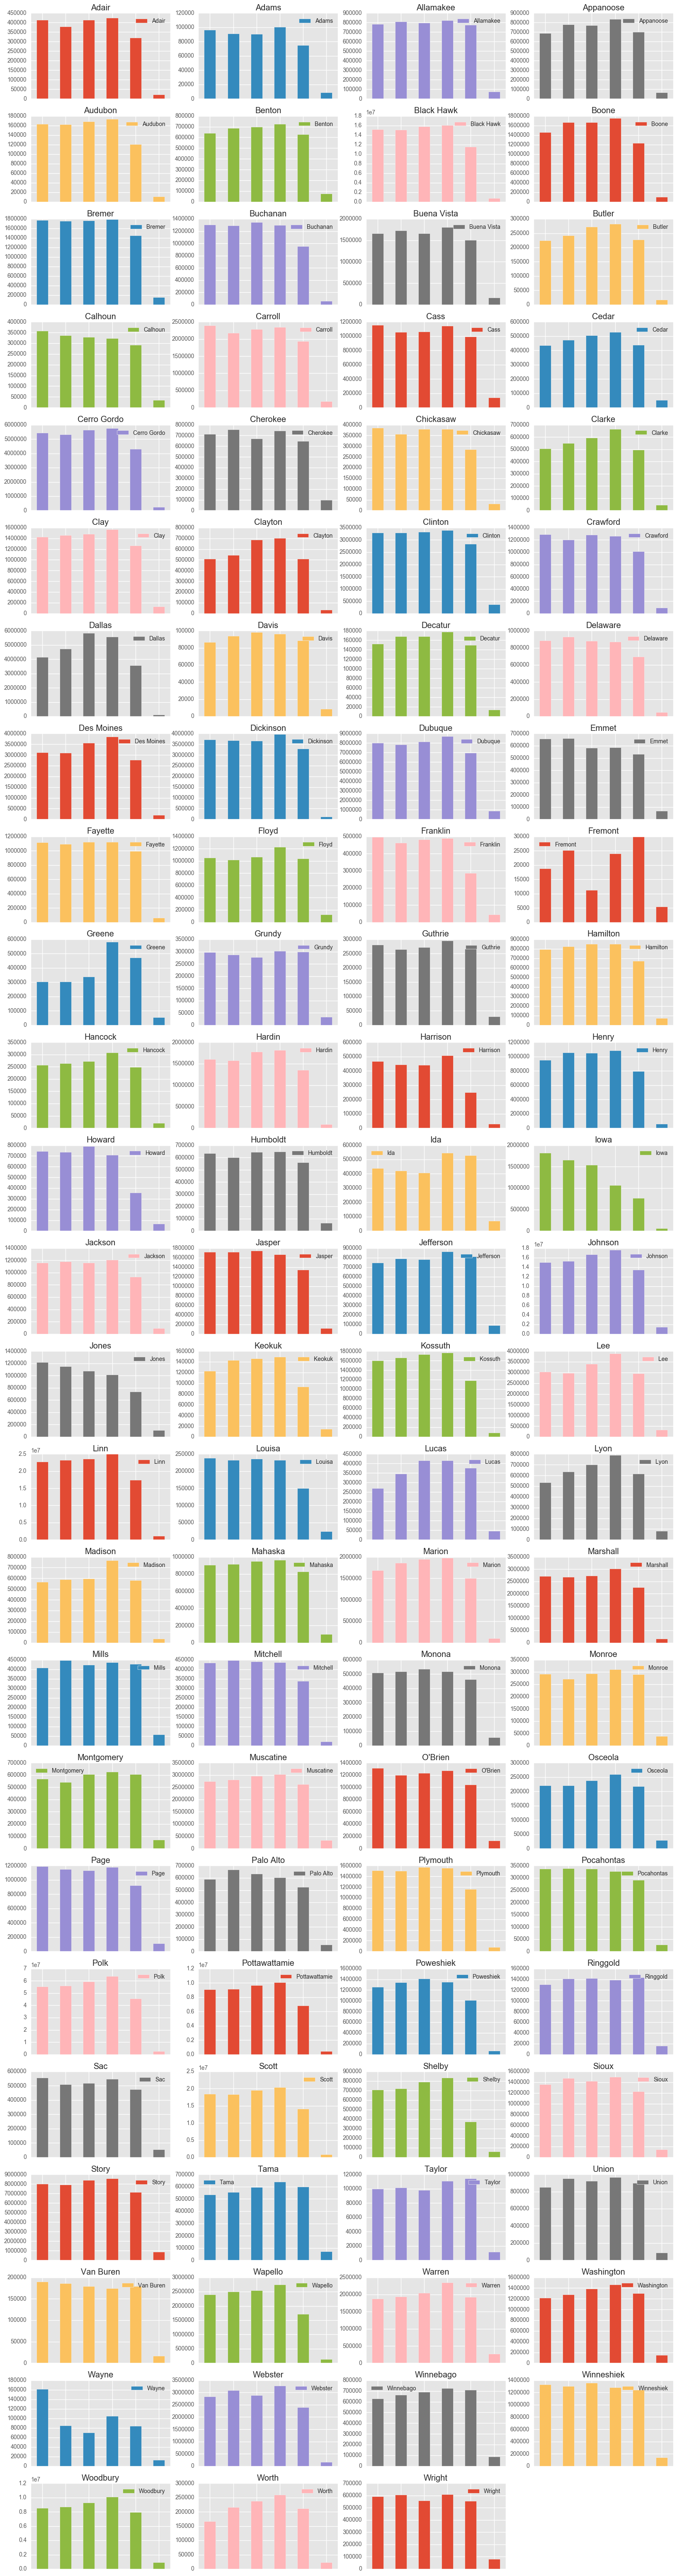

In [14]:
ax = county_pivot.resample('BA').sum().plot.bar(subplots=True, layout=(34,4), figsize=(20, 120))
plt.gcf().autofmt_xdate()

In [15]:
cur.execute("""SELECT date, store, city, zipcode, county, category_name, item_desc, bottle_volume_ml,
               state_bottle_cost, state_bottle_retail, sale_bottles, sale_dollars, sale_liters, 
               sale_gallons FROM iowa_sales
               WHERE date > '2016-01-01T12:00:00'
               ORDER BY date ASC""")
rows = cur.fetchall()

In [16]:
iowaSales = pd.DataFrame(rows, columns=['date','store','city','zipcode','county','category_name','item_desc',
                                        'bottle_volume_ml','state_bottle_cost','state_bottle_retail',
                                        'sale_bottles','sale_dollars','sale_liters','sale_gallons'])

###### Sales for 2016 and January - February of 2017

In [17]:
iowaSales = pd.read_pickle('data/iowaSales.pkl')

In [18]:
iowaSales.head()

,store,city,zipcode,county,bottle_volume_ml,state_bottle_cost,state_bottle_retail,sale_bottles,sale_dollars,sale_liters,...,types_beer,types_bourbon,types_brandy,types_gin,types_other,types_rum,types_scotch,types_tequila,types_vodka,types_whiskey
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,2539,Iowa Falls,50126,Hardin,750.0,11.49,17.24,4,68.96,3.00,...,0,0,0,0,0,0,0,0,1,0
2016-01-04,2643,Waterloo,50701,Black Hawk,750.0,19.58,29.37,12,352.44,9.00,...,0,0,0,0,0,0,0,0,0,1
2016-01-04,2643,Waterloo,50701,Black Hawk,750.0,3.57,5.36,12,64.32,9.00,...,0,0,0,0,0,0,0,0,1,0
2016-01-04,4067,Wellman,52356,Wapello,375.0,9.00,13.50,1,13.50,0.38,...,0,0,0,0,0,0,0,0,1,0
2016-01-04,5142,Cedar Rapids,52303,Linn,750.0,3.34,5.01,12,60.12,9.00,...,0,0,0,0,0,0,0,0,1,0


# Data Wrangling

In [19]:
Clean all columns containing text
iowaSales['city'] = format_text(iowaSales['city'])
iowaSales['county'] = format_text(iowaSales['county'])
iowaSales['category_name'] = format_text(iowaSales['category_name'])
iowaSales['item_desc'] = format_text(iowaSales['item_desc'])
iowaSales['county'] = iowaSales['county'].apply(clean_county)

In [20]:
iowaSales['state_bottle_cost'] = money_toFloat(iowaSales['state_bottle_cost'])
iowaSales['state_bottle_retail'] = money_toFloat(iowaSales['state_bottle_retail'])
iowaSales['sale_dollars'] = money_toFloat(iowaSales['sale_dollars'])

In [21]:
county_dict = iowaSales.groupby(['store'])['county'].unique().to_dict()

In [22]:
for k,v in county_dict.items():
    if v[0] == 'None' and len(v) == 1:
        print(k)

In [23]:
iowaSales.loc[iowaSales['store'] == '4308', 'county'] = 'Johnson'
iowaSales.loc[iowaSales['store'] == '5220', 'county'] = 'Cerro Gordo'

In [24]:
county_dict = {k:v[0] if v[0] != 'None' else v[1] for k, v in county_dict.items()}

In [25]:
iowaSales['county'] = iowaSales['county'].apply(lambda x: np.nan if x == 'None' else x )
iowaSales['county'] = iowaSales['county'].fillna(iowaSales['store'].map(county_dict))

In [26]:
iowaSales['date'] = iowaSales['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
iowaSales.set_index(['date'], inplace=True)

# Data Mining

Create necessary derived columns from the data:
1. Number of Transactions
2. Profit Margin for the State
3. More General Category Types

In [27]:
iowaSales['number_of_transactions'] = pd.Series(np.ones(iowaSales.shape[0]))
iowaSales["profit"] = (iowaSales["state_bottle_retail"] - iowaSales["state_bottle_cost"]) * iowaSales["sale_bottles"]
iowaSales['desc'] = iowaSales['category_name'] + ' ' + iowaSales['item_desc'] 
iowaSales['desc'] = iowaSales['desc'].apply(lambda x: str(x).lower())

In [28]:
types = ['beer','bourbon','brand+','gin+','rum','scotch','tequila','vodka+','whisk+','wine']

In [29]:
pattern = '(%s)' % '|'.join(types) 
iowaSales['types'] = iowaSales['desc'].str.extract(pattern, expand=False)

In [30]:
iowaSales.drop(['category_name','item_desc','desc'], axis=1, inplace=True)

In [31]:
iowaSales['types'] = iowaSales['types'].str.replace('brand', 'brandy').str.replace('whisk', 'whiskey')
iowaSales['types'].fillna('other', inplace=True)

In [32]:
iowaSales = pd.get_dummies(iowaSales, columns=['types'])

###### Sales in 2016 only

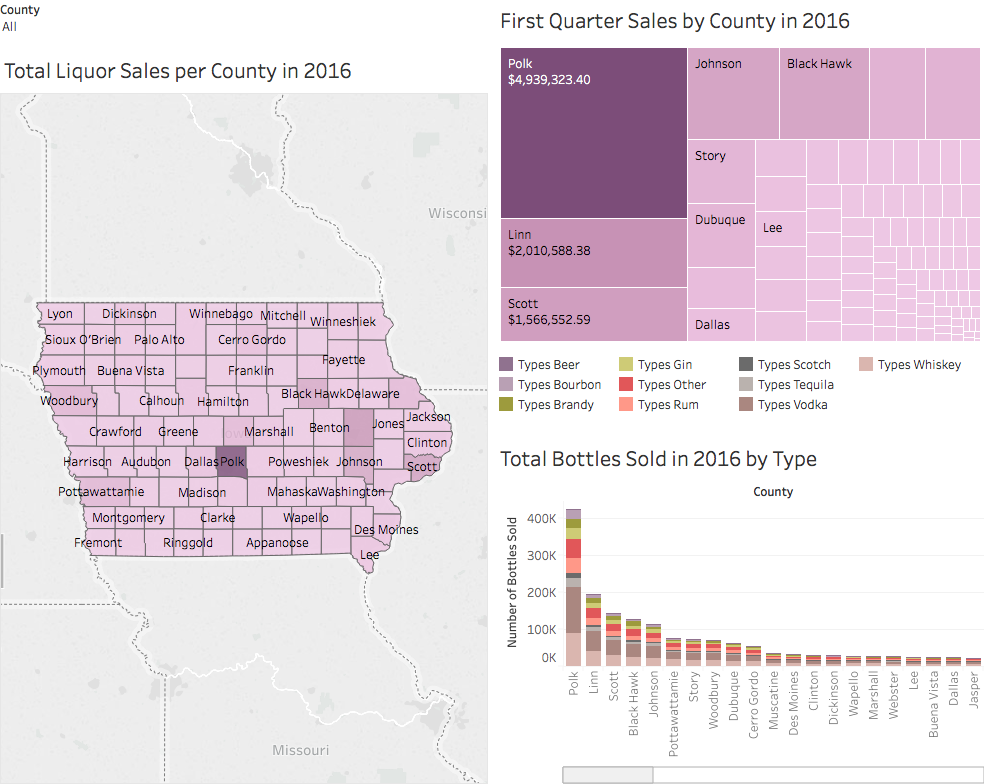

In [33]:
from IPython.display import Image
Image('image/2016 Iowa Liquor Sales.png')

In [34]:
sales_2016 = iowaSales['2016-01-01':'2016-12-31']

###### 2016 Sales by Stores

In [35]:
by_store = sales_2016.groupby(['store'])[iowaSales.columns].sum()

In [36]:
by_store.reset_index(level=(0), inplace=True)

In [37]:
q1_dict = iowaSales['2016-01-01':'2016-03-31'].groupby(['store'])['sale_dollars'].sum().to_dict()
by_store['q1_2016'] = by_store['store'].apply(lambda x: q1_dict[x] if x in q1_dict.keys() else 0)

In [38]:
corr = abs(by_store.corr()['sale_dollars'])
corr.sort_values(inplace=True, ascending=False)
corr

sale_dollars              1.000000
profit                    0.997875
sale_gallons              0.991787
sale_liters               0.991786
q1_2016                   0.990878
sale_bottles              0.987294
types_tequila             0.845250
state_bottle_cost         0.811887
state_bottle_retail       0.811839
types_other               0.807350
types_gin                 0.798713
bottle_volume_ml          0.776526
number_of_transactions    0.764592
types_vodka               0.754593
types_bourbon             0.737063
types_scotch              0.734973
types_rum                 0.733813
types_whiskey             0.652380
types_brandy              0.468355
types_beer                0.440569
Name: sale_dollars, dtype: float64

In [39]:
X = by_store.drop(['profit','sale_dollars','store'], axis=1)
y = by_store['sale_dollars']

feature_names = X.columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [40]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
ls = Lasso(alpha=1000.0, random_state=0)
ls.fit(X_train, y_train)

Lasso(alpha=1000.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False)

In [42]:
print("MAE train score {}".format(score_me(mean_absolute_error, ls, X_train, y_train)))
print("MAE test score {}".format(score_me(mean_absolute_error, ls, X_test, y_test)))
print("MSE train score {}".format(score_me(mean_squared_error, ls, X_train, y_train)))
print("MSE test score {}".format(score_me(mean_squared_error,ls, X_test, y_test)))
print("R2  train score {}".format(score_me(r2_score, ls, X_train, y_train)))
print("R2  test score {}".format(score_me(r2_score, ls, X_test, y_test)))

MAE train score 16028.962543
MAE test score 16958.9402474
MSE train score 833122220.451
MSE test score 970696653.202
R2  train score 0.995542385365
R2  test score 0.985489718652


###### Most Important Predictor for Profit by Stores is Quarter One Sales 

In [43]:
top_features(feature_names, ls.coef_)

,features,coefficients
17,q1_2016,198261.782293
4,sale_liters,139626.626448
3,sale_bottles,70687.863868
1,state_bottle_cost,47044.976170
16,types_whiskey,-15495.559393
9,types_brandy,-5938.174623
7,types_beer,-3956.573036
14,types_tequila,2131.804833
5,sale_gallons,144.389369
6,number_of_transactions,-0.000000


###### Sales in the First 2 Months of 2017

In [44]:
sales_2017 = iowaSales['2016-12-31':].groupby(['store','county'])[iowaSales.columns].sum()

###### Changed sales_dollars to q1 since we only have data for Jan and Feb 2017

In [45]:
sales_2017['q1_2016'] = sales_2017['sale_dollars']

In [46]:
X = sales_2017.drop(['profit','sale_dollars'], axis=1)

In [47]:
X = scaler.fit_transform(X)

In [48]:
sales_2017['total_sales_prediction'] = ls.predict(X)

###### Total Projected Sales for Iowa in 2017

In [49]:
sales_2017['total_sales_prediction'].sum()

2.409099719656925

In [50]:
county_pivot['Fremont'].fillna(0, inplace=True)

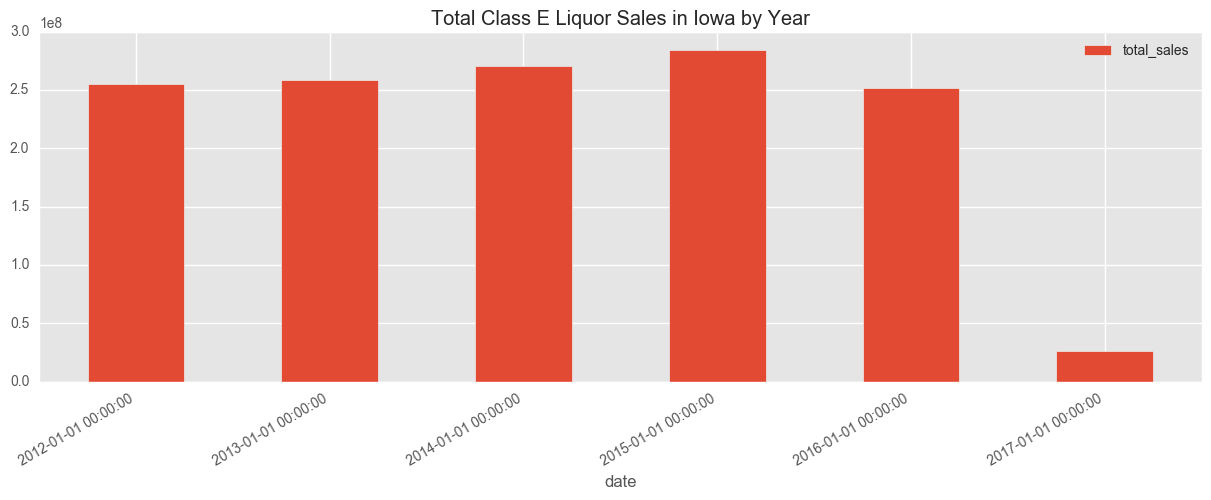

In [55]:
ax = by_year.plot.bar(figsize=(15,5), title="Total Class E Liquor Sales in Iowa by Year")
plt.gcf().autofmt_xdate()

In [52]:
sales_2017.reset_index(level=(1), inplace=True)

In [53]:
totalSales = sales_2017.groupby(['county'])['total_sales_prediction'].sum().to_dict()

In [56]:
df = pd.read_csv('data/type_county.csv')[['county','fips_5']]

In [57]:
df['projectedSales'] = df['county'].apply(lambda x: totalSales[x] if x in totalSales.keys() else 0)

In [58]:
df.to_csv('data/projectedSales.csv')

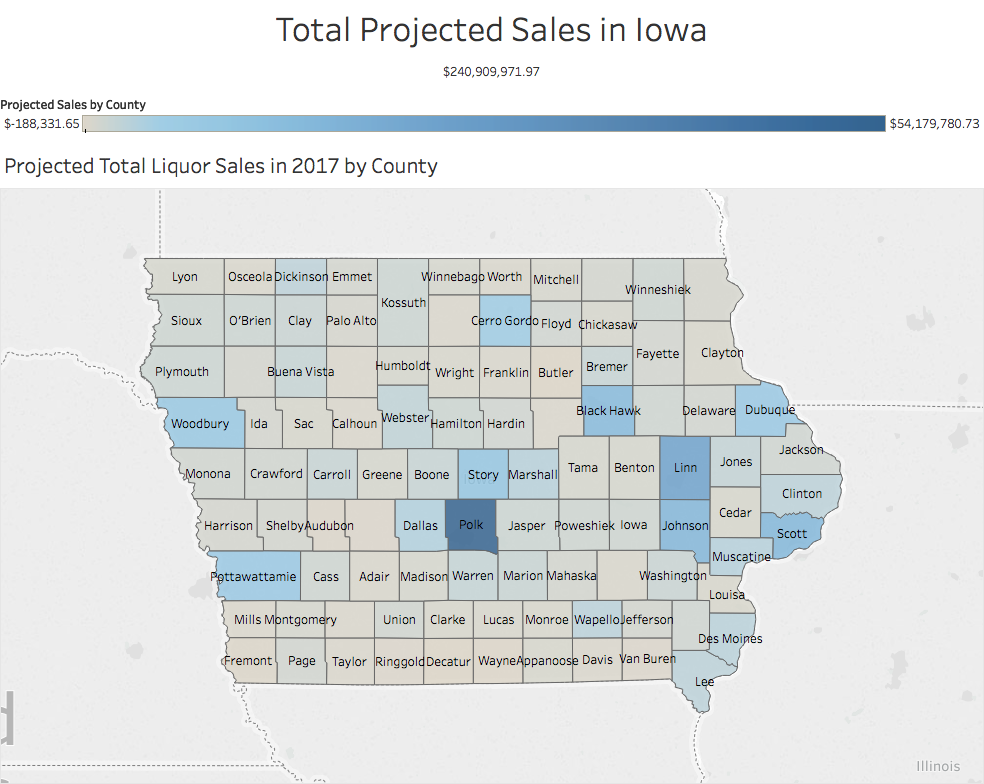

In [59]:
from IPython.display import Image
Image('image/ProjectedIowaSales.png')